In [1]:
%matplotlib inline

import missingno as msn
import pandas as pd
import numpy as np

import sys
import os
import pickle
import lightgbm as lgb

from correlation import select_genes, select_genes_mic
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import LabelEncoder

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
clinical = pd.read_csv('data/clinical.tsv', sep='\t', index_col='ID')

genecount = pd.read_csv('data/gene_count.tsv', sep='\t', index_col='ID')

clinical_gene = clinical.join(genecount, how='inner')

clinical_gene.shape

(749, 27833)

In [3]:
fish_vars = [
    '13q14', '13q34', '17p13', '1q21', '11p15', '15q15', '19q13', '20q13', '21q22', '3q21',
    '5q31', '7q22', '9q33', 't_11_14_ccnd1', 't_12_14_ccnd2', 't_14_16_maf', 't_14_20_mafb',
    't_4_14_whsc1',  't_6_14_ccnd3', 't_8_14_mafa', 't_8_14_myc', 'hyperdiploid_flag']

In [4]:
clinical_description = {'variable': [], 'type': [], 'number of values': [], 'sample':[], 'nas': [], 'count': []}

selected_variables = []

for c in clinical.columns[2:]:
    
    if c in fish_vars or (clinical_gene[c].dtype != 'object' and c != 'iss'):
        continue
        
    selected_variables.append(c)    
    
    clinical_description['variable'].append(c)
    
    clinical_description['type'].append(str(clinical_gene[c].dtype))
    
    nvalues = len(clinical_gene[c].unique())
    
    clinical_description['number of values'].append(nvalues)
    
    clinical_description['nas'].append(clinical_gene[c].isnull().sum())
    
    clinical_description['count'].append((~clinical_gene[c].isnull()).sum())
    
    try:
        clinical_description['sample'].append(', '.join([str(v) for v in clinical_gene[c].unique()[:min(5, nvalues)]]))
        
    except:
        clinical_description['sample'].append(None)

clinical_description = pd.DataFrame(clinical_description)

clinical_description

,variable,type,number of values,sample,nas,count
0,ecog_ps,object,6,PS 1 (Restricted in physically strenuous activ...,177,572
1,cell_markers,object,5,"CD13, CD117, CD138, nan, CD38",114,635
2,iss,float64,4,"1.0, 2.0, 3.0, nan",20,729
3,family_cancer,object,4,"Yes, Unk, No, nan",111,638
4,gender,object,2,"Female, Male",0,749
5,race,object,5,"White, Asian, Black/African American, Other, nan",111,638
6,therapy_first_line,object,7,"Bor-Len-Dex, nan, Bor-Cyc-Dex, Len-Dex, Bor-Dex",239,510
7,therapy_first_line_class,object,8,"nan, Combined bortezomib/IMIDs-based, Bortezom...",39,710
8,first_line_transplant,object,2,"Yes, No",0,749


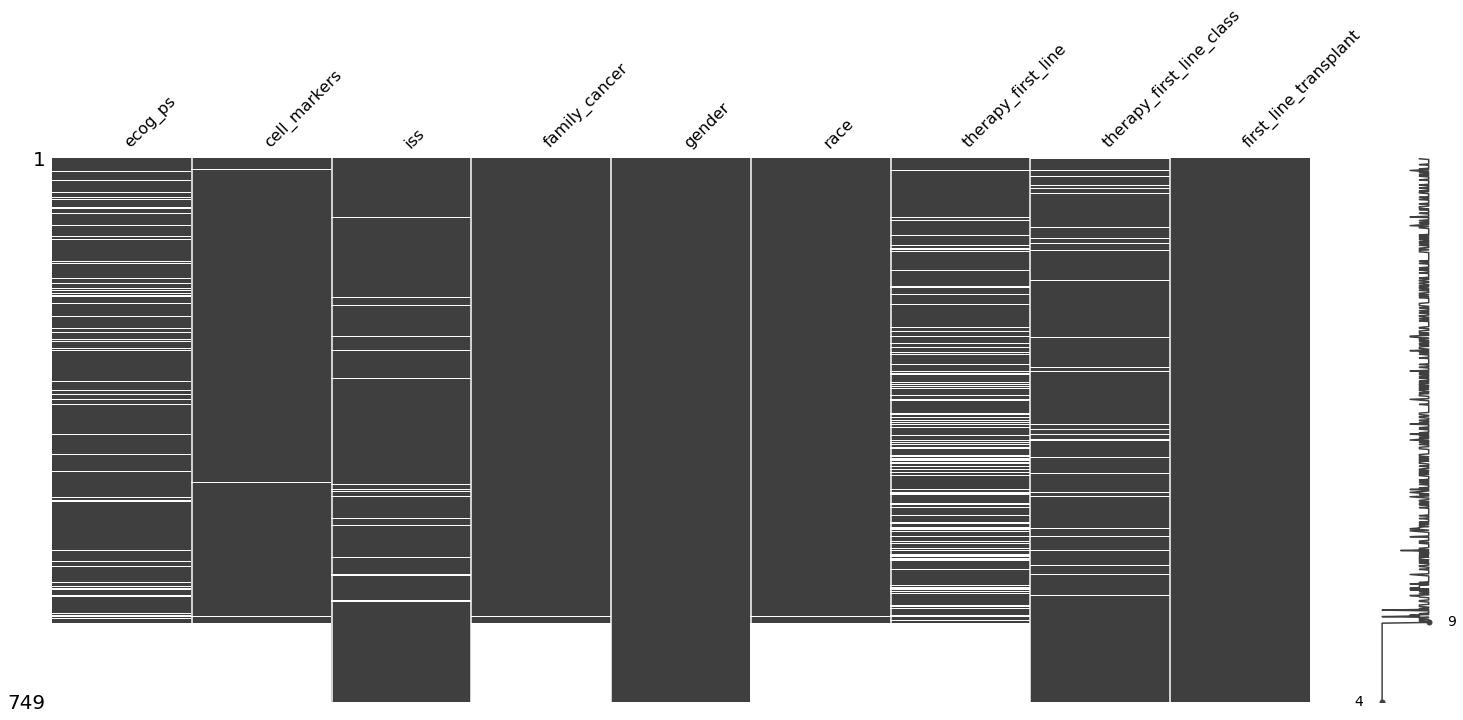

In [5]:
msn.matrix(clinical_gene[selected_variables]);

In [11]:
space  = [
    Real(1e-6, 9e-1, 'log-uniform', name='learning_rate'),
    Integer(7, 4095, name='num_leaves'),
    Integer(2, 100, name='max_depth'),
    Integer(1, 4000, name='scale_pos_weight'),
    Real(0.01, 1.5, name='min_child_weight'),
    Real(0.4, .9, name='colsample_bytree'),
    Real(0.001, 100, 'log-uniform', name='min_split_gain'),
    Integer(1, 50, name='min_child_samples'),
    Real(0.4, 0.9, name='subsample')]

def optimize_multiclass(x, y, space, n_calls=50):
    
    @use_named_args(space)
    def objective(num_leaves, max_depth, scale_pos_weight, min_child_weight, colsample_bytree, learning_rate,
                  min_split_gain, min_child_samples, subsample):
        
        scores = []

        params = {
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'scale_pos_weight': int(scale_pos_weight),
            'min_child_weight': min_child_weight,
            'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
  
            'subsample_for_bin': 2,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'eval_metric': 'multi_logloss',
            'is_unbalance':False,
            'nthread':24,          
            'verbose': -1}
            
        params['num_class'] = len(np.unique(y))

        kf = StratifiedKFold(5, shuffle=True, random_state=185)  
        
        for train_index, valid_index in kf.split(x, y):
            
            lgb_train = lgb.Dataset(x[train_index,:], y[train_index])
            
            lgb_valid = lgb.Dataset(x[valid_index,:], y[valid_index])
            
            gbm = lgb.train(params, lgb_train, num_boost_round=1000,  
                            valid_sets=lgb_valid, early_stopping_rounds=100, verbose_eval=False) 
            
            y_hat = gbm.predict(x[valid_index,:], num_iteration=gbm.best_iteration, verbose_eval=False)
            
            scores.append(log_loss(y[valid_index], y_hat))
        
        return np.mean(scores)
    
    return gp_minimize(objective, space, n_calls=n_calls, random_state=22, verbose=False, n_jobs=-1)

In [14]:
losses = {'var': [], 'logloss': []}

clinical_gene_to_fill = clinical_gene[selected_variables].copy()

for t in selected_variables:
    
    print('Filling variable {}'.format(t))
    
    encoder = LabelEncoder()
    
    try:
        
        categorical = clinical_gene[t]

        categorical_fill = categorical[~categorical.isnull()]
        categorical_unfill = categorical[categorical.isnull()]

        train = pd.DataFrame(categorical_fill).join(genecount, how='inner')
        valid = pd.DataFrame(categorical_unfill).join(genecount, how='inner')

        x_train, y_train = train.iloc[:,1:], encoder.fit_transform(train.iloc[:,0])
        x_valid, y_valid = valid.iloc[:,1:], valid.iloc[:,[0]]
        
        if x_valid.shape[0] < 10:
            print('Variable with less than 10 missing values. Ignoring it\n')
            continue
        
        #
        #
        #
        file_name = 'output/fill/multiclass_selected_genes_{}.pkl'.format(t)

        if os.path.exists(file_name):
            with open(file_name, 'rb') as file:
                selected_genes = pickle.load(file)

        else:
            
            print('Feature selection')

            dummies = pd.get_dummies(y_train)

            selected_genes, pvalues = [], []

            for c in dummies.columns:
                
                sg, pv = select_genes(x_train, dummies[c].values, threshold=0.05)
                
                selected_genes += sg
                
                pvalues += pv 
            
            pd.DataFrame({'gene': selected_genes, 'pvalue': pvalues}).to_csv(file_name.replace('pkl', 'csv'), sep=',', index=False)
            
            selected_genes = selected_genes[:min(500, len(selected_genes))]

            with open(file_name, 'wb') as file:
                pickle.dump(selected_genes, file)

        print('{} selected genes for translocation {}'.format(len(selected_genes), t))

        x_train, x_valid = x_train[selected_genes], x_valid[selected_genes]

        file_name = 'output/fill/multiclass_{}.lgbm'.format(t)

        if os.path.exists(file_name):
            gbm = lgb.Booster(model_file=file_name)

        else:
            #
            # Optimization
            #
            print('Optimization')
            
            opt = optimize_multiclass(x_train.values, y_train, space, n_calls=10).x
            
            #
            # LightGBM
            #    
            print('Training')
            
            params = {
                'learning_rate': opt[0],
                'num_leaves': opt[1],
                'max_depth': opt[2],
                'scale_pos_weight': opt[3],
                'min_child_weight': opt[4],
                'colsample_bytree': opt[5],
                'min_split_gain': opt[6],
                'min_child_samples': opt[7],
                'subsample': opt[8],

                'subsample_for_bin': 2,
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'eval_metric': 'multi_logloss',
                'is_unbalance':False,
                'nthread':24,          
                'verbose': -1}
            
            params['num_class'] = len(np.unique(y_train))

            opt_kf = StratifiedKFold(5, shuffle=True, random_state=185) 

            y_train = encoder.fit_transform(y_train)
            
            for opt_train, opt_valid in opt_kf.split(x_train, y_train):
                
                lgb_train = lgb.Dataset(x_train.values[opt_train,:], y_train[opt_train].reshape((-1,)))
                
                lgb_valid = lgb.Dataset(x_train.values[opt_valid,:], y_train[opt_valid].reshape((-1,)))

                gbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=1000, 
                                early_stopping_rounds=100, verbose_eval=False)    
                
                logloss = log_loss(y_train[opt_valid], gbm.predict(x_train.values[opt_valid,:]))
                
                losses['var'].append(t)
                
                losses['logloss'].append(logloss)
                
                break
                
            #
            #
            #
            gbm.save_model(file_name, num_iteration=gbm.best_iteration) 
        
        clinical_gene_to_fill.loc[categorical_unfill.index, t] = encoder.inverse_transform(np.argmax(gbm.predict(x_valid), axis=1))
    
    except Exception as e:
        
        exc_type, exc_obj, exc_tb = sys.exc_info()
        
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        
        print('Some error with translocation {}: {} ({}, {}, {})'.format(t, e, exc_type, fname, exc_tb.tb_lineno))       
    
    print('')

Filling variable ecog_ps
Feature selection
500 selected genes for translocation ecog_ps
Optimization
Training

Filling variable cell_markers
Feature selection
500 selected genes for translocation cell_markers
Optimization


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Some error with translocation cell_markers: y_true and y_pred contain different number of classes 3, 4. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2] (<class 'ValueError'>, <ipython-input-14-dff6951cf62a>, 75)

Filling variable iss
Feature selection
500 selected genes for translocation iss
Optimization
Training

Filling variable family_cancer
Feature selection
500 selected genes for translocation family_cancer
Optimization
Training

Filling variable gender
Variable with less than 10 missing values. Ignoring it

Filling variable race
Feature selection
500 selected genes for translocation race
Optimization
Training

Filling variable therapy_first_line
Feature selection
500 selected genes for translocation therapy_first_line
Optimization


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Some error with translocation therapy_first_line: y_true and y_pred contain different number of classes 5, 6. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 5] (<class 'ValueError'>, <ipython-input-14-dff6951cf62a>, 75)

Filling variable therapy_first_line_class
Feature selection
500 selected genes for translocation therapy_first_line_class
Optimization


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Some error with translocation therapy_first_line_class: y_true and y_pred contain different number of classes 6, 7. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4 6] (<class 'ValueError'>, <ipython-input-14-dff6951cf62a>, 75)

Filling variable first_line_transplant
Variable with less than 10 missing values. Ignoring it



{'var': ['ecog_ps', 'iss', 'family_cancer', 'race'],
 'logloss': [1.1726382723395892,
  1.0376855983561666,
  0.9597614360473372,
  0.7104835264411608]}